In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algs import *
from utils import *
from tests import *

%matplotlib inline

In [2]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Datasize: ", m, ", dimension: ", n)

Datasize:  32561 , dimension:  123
Wall time: 423 ms


In [3]:
%%time
dataset = "a9a"
num_of_workers = 16
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)
print("Sparsity of A: ", sparsity_A)

Smoothness constant of f         :  1.5719196992226587
Average smoothness const of f_ij :  3.467276803535652
Worst smoothness const of f_ij   :  3.5
Sparsity of A:  0.11275696922074716
Wall time: 15 ms


In [4]:
%%time
dataset = "w8a"
A, y, m, n, sparsity_A = prepare_data(dataset)
denseA = A.toarray()
L, average_L, worst_L = compute_L(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

Datasize:  49749 , dimension:  300
Smoothness constant of f         :  0.661199384494479
Average smoothness const of f_ij :  2.912551006050437
Worst smoothness const of f_ij   :  28.5
Wall time: 571 ms


In [5]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L/1000
l1 = 0

In [6]:
%%time
param = [A, y, l2, False, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-30)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.17403451324630026
      fun: 0.17403451324630026
 hess_inv: <300x300 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.28145150e-12,  3.18267889e-12, -3.33306624e-13, -3.02681957e-12,
        8.22951917e-12, -2.93118313e-12,  5.75092220e-13, -3.41261692e-12,
       -1.67192063e-12,  3.37124176e-12, -2.59587870e-12,  2.97334873e-12,
       -7.37762716e-14,  2.45168675e-12, -1.87102430e-12,  4.92048394e-12,
        1.89814388e-11,  6.20148442e-12,  1.90652865e-12, -1.48763320e-12,
       -4.02485575e-12,  1.59329480e-12,  3.17124051e-12, -1.97621043e-12,
       -3.20564999e-13,  2.09680434e-12,  1.10943860e-12, -1.12524345e-12,
       -2.43347280e-13,  1.90419501e-12,  2.31119545e-12, -9.06573373e-13,
       -7.15626885e-13,  1.72982960e-12,  1.06890731e-11,  1.18597414e-12,
       -3.82836785e-12,  4.38436538e-12, -2.12958646e-12, -4.13701739e-12,
        7.09695788e-13, -1.76875113e-12, -1.76875113e-12, -2.36573565e-13,
        9.31270631e-13,  3.58822069e-12,  1.3386

In [7]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

In [8]:
%%time
dataset = "w8a"
A, y, m, n, sparsity_A = prepare_data(dataset)
denseA = A.toarray()
L, average_L, worst_L = compute_L(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)
num_of_workers = 16

Datasize:  49749 , dimension:  300
Smoothness constant of f         :  0.661199384494479
Average smoothness const of f_ij :  2.912551006050437
Worst smoothness const of f_ij   :  28.5
Wall time: 497 ms


In [9]:
shift_param = 1.0
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = L/1000
l1 = 0
batch_size = int(0.01*m)
batch_size0 = 1
batch_size1 = int(0.01*m)
num_of_byz = 3
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)

sparse_full = True
sparse_stoch = True

In [10]:
print("f(x^0) = ", logreg_loss(x_init, [denseA,y,l2,False,0]))
print("f(x^*) = ", f_star)

f(x^0) =  5.967422233116459
f(x^*) =  0.17403451324630026


In [11]:
%%time
attack = "BF"
agg = "GM"
S = 40
save_info_period = 30 
gamma = 5/(2*L)
num_of_byz = 3
p = 1.0 * batch_size / m
res = br_l_svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, num_of_byz=num_of_byz, p=p, num_of_workers=num_of_workers,
     attack=attack, agg=agg, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 1min 22s


In [13]:
%%time
attack = "LF"
agg = "GM"
S = 40
save_info_period = 30 
gamma = 5/(2*L)
num_of_byz = 3
p = 1.0 * batch_size / m
res = br_l_svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, num_of_byz=num_of_byz, p=p, num_of_workers=num_of_workers,
     attack=attack, agg=agg, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 1min 27s


In [15]:
%%time
attack = "IPM"
agg = "GM"
S = 40
save_info_period = 30 
gamma = 5/(2*L)
num_of_byz = 3
p = 1.0 * batch_size / m
res = br_l_svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, num_of_byz=num_of_byz, p=p, num_of_workers=num_of_workers,
     attack=attack, agg=agg, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 1min 3s


In [17]:
%%time
attack = "ALIE"
agg = "GM"
S = 40
save_info_period = 30 
gamma = 5/(2*L)
num_of_byz = 3
p = 1.0 * batch_size / m
res = br_l_svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, num_of_byz=num_of_byz, p=p, num_of_workers=num_of_workers,
     attack=attack, agg=agg, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 1min 3s


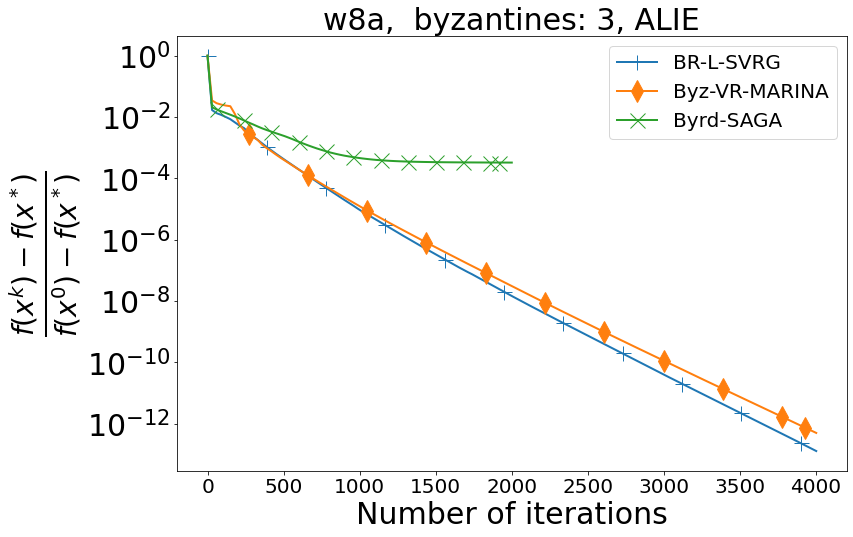

In [22]:
p0 = 1.0 * batch_size0 / m
p1 = 1.0 * batch_size1 / m
attack = "ALIE"
methods = [
    ['BR_L_SVRG', [gamma, l2, p, 40, num_of_workers, batch_size, num_of_byz, attack, agg], 
           "BR-L-SVRG", None],
    ['Byz_VR_MARINA', [gamma, l2, p, 40, num_of_workers, batch_size, num_of_byz, attack, agg], 
           "Byz-VR-MARINA", None],
    ['Byrd_SAGA', [gamma, l2, 20, num_of_workers, batch_size, num_of_byz, attack, agg], 
           'Byrd-SAGA', None]
]
mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+" byzantines: "+str(num_of_byz)+", "+attack
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_All_"+attack+"_"+agg+"_epochs_"+str(S)+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_byz_"+str(num_of_byz)+"_batch_"+str(batch_size)+"_iters.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

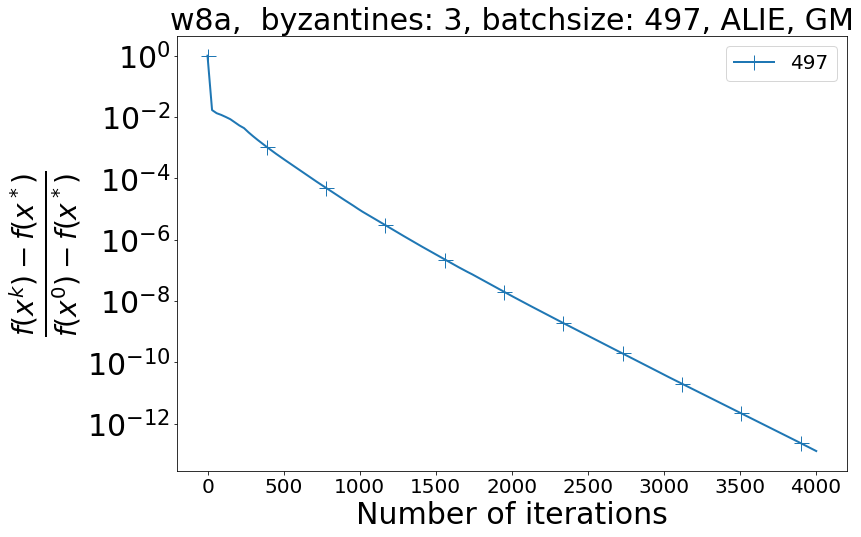

In [18]:
methods = [
    ['BR_L_SVRG', [gamma, l2, p, S, num_of_workers, batch_size, num_of_byz, attack, agg], 
           str(batch_size), None]
]
mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+" byzantines: "+str(num_of_byz)+", batchsize: "+str(batch_size)+", "+attack+", "+agg
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_BR_L_SVRG_one_"+attack+"_"+agg+"_epochs_"+str(S)+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_byz_"+str(num_of_byz)+"_batch_"+str(batch_size)+"_iters.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

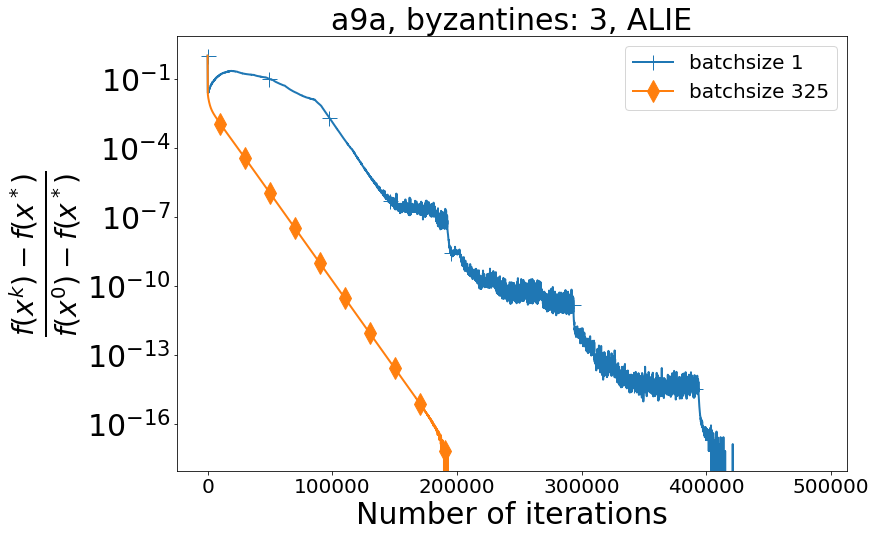

In [59]:
p0 = 1.0 * batch_size0 / m
p1 = 1.0 * batch_size1 / m
attack = "ALIE"
methods = [
    ['BR_L_SVRG', [gamma, l2, p0, 15, num_of_workers, batch_size0, num_of_byz, attack, agg], 
           "batchsize 1", None],
    ['BR_L_SVRG', [gamma, l2, p1, 2000, num_of_workers, batch_size1, num_of_byz, attack, agg], 
           "batchsize "+str(batch_size1), None]
]
mode_y = 'func_vals'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 20
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+"byzantines: "+str(num_of_byz)+", "+attack
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_BR_L_SVRG_both_"+attack+"_"+agg+"_epochs_"+str(S)+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_byz_"+str(num_of_byz)+"_batch_"+str(batch_size)+"_iters.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)